In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model.graph_utils import JunctionTree

from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
# from metal.label_model import LabelModel
# from metal.label_model.utils import (
#     compute_mu,
#     compute_covariance,
#     compute_inv_covariance,
#     print_matrix,
#     visualize_matrix
# )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


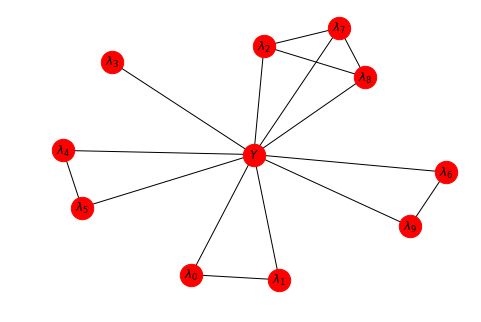

In [42]:
M = 10
N_CLUSTERS = 5
deps_graph = ClusterDependencies(M, N_CLUSTERS)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

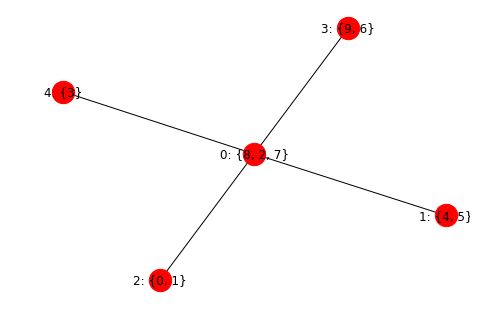

In [43]:
N = 1000 # Not used yet...
K = 2
data = DataGenerator(N, M, k=K, deps_graph=deps_graph)
data.jt.draw()

In [47]:
targets = {0:1, 2:1, M:1}

In [48]:
%%time
p = data.P_marginal_brute_force(targets)
print(p)

0.011537343058460164
CPU times: user 3.75 s, sys: 5.3 ms, total: 3.76 s
Wall time: 3.76 s


In [49]:
%time data.P_marginal(targets)

CPU times: user 2.41 ms, sys: 13 µs, total: 2.42 ms
Wall time: 2.42 ms


0.011737448129562083

### TODOs

1. Compute $\Sigma_O^{-1}$
    - Make `iter_index` method just for $O$...
2. Refactor `LabelModel` to solve for $\mu$ given $\Sigma_O^{-1}$ as input rather than `L`
3. Check performance with `ClusterDependencies` and unary cliques
4. Check performance with `ClusterDependencies` and higher-order cliques
5. _Go back to debugging `ChainDependencies`..._

In [ ]:
for vals in data.jt.iter_index():
    print(vals)

## Trying to recover the _unary_ clique marginals

We have:
$$
K_O = \Sigma^{-1}_O + zz^T
$$